In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

C:\Users\micsa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Training Data
season_stats = pd.read_csv('Seasons_Stats.csv')
season_stats = season_stats.drop(['blanl', 'blank2', 'Unnamed: 0'], axis=1)
season_stats = season_stats[season_stats.Tm.str.contains('TOT') == False]
# Maybe use this for classification?
season_stats['MVP_Candidate'] = np.where(season_stats['MVPSHARES'] > 0, 'Yes', 'No')
season_stats['Player'] = season_stats['Player'].astype(str).str.replace('*', '')
season_stats['PPG'] = season_stats['PTS'] / season_stats['G']
season_stats['ASTPG'] = season_stats['AST'] / season_stats['G']
season_stats['STLPG'] = season_stats['STL'] / season_stats['G']
season_stats['BLKPG'] = season_stats['BLK'] / season_stats['G']
season_stats['PFPG'] = season_stats['PF'] / season_stats['G']
season_stats['TRPG'] = season_stats['TRB'] / season_stats['G']
season_stats['ORPG'] = season_stats['ORB'] / season_stats['G']
season_stats['DRPG'] = season_stats['DRB'] / season_stats['G']
season_stats['MPPG'] = season_stats['MP'] / season_stats['G']
season_stats['TOVPG'] = season_stats['TOV'] / season_stats['G']
season_stats = season_stats[season_stats['G'] >= 41.0]
season_stats = season_stats[season_stats['MPPG'] >= 25.0]
season_stats['Year'] = season_stats['Year'].astype(int)

season_stats = season_stats.dropna()

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

feat_todrop = ['FG', 'FGA', '3P','3PA', '2P', '2PA', 'Tm', 'Pos', 'Player', 'Decade',
               'MVPSHARES', 'MVP_Candidate', 'MVP', 'ORPG', 'OWS', 'TRB%', 'BPM', 'TRPG', 'FG%', 'MP', 'TOV',
              'FT', 'FTA', 'WS/48', 'ASTPG', 'BLKPG', 'PPG', 'STLPG', 'DRPG', 'PF',
              'TRB', 'PTS', 'STL', 'TOVPG', 'AST%', 'BLK%', '2P%', 'DWS', 'G', 'GS', 'Age', 'Year', 'ORB%', 'DRB%']
feat_to_use = ['WS', 'PER', 'TMWL%', 'PPG', 'BPM']
               
               #'PPG', 'USG%', 'ASTPG', 'VORP', 
               #'BLKPG', 'FG%', 'STLPG', 'TRPG']

#df = season_stats.drop(feat_todrop, axis=1)
df = season_stats[feat_to_use]
X = add_constant(df)
vif = pd.Series([variance_inflation_factor(X.values, i)
         for i in range (X.shape[1])],
          index=X.columns)
vif = pd.DataFrame(vif, columns = ['vif_score'])
vif.sort_values('vif_score', ascending=False)

,vif_score
const,67.216576
PER,5.833101
WS,5.214202
BPM,3.930752
PPG,2.934180
TMWL%,1.645705


In [7]:
from sklearn.model_selection import train_test_split
y = season_stats['MVPSHARES']
X = df


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)
print(cross_val_score(rf, X_test, y_test, cv=10))
print(rf.score(X_test,y_test))

[0.8310892  0.1931482  0.75531505 0.70054167 0.88282195 0.17863506
 0.5633536  0.61046617 0.75271841 0.8737533 ]
0.7333411178565251


In [8]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num= 11)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [13]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, cv = 3, verbose=2, random_state=42,
                              n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [14]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [15]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.0148 degrees.
Accuracy = -inf%.


In [16]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.0143 degrees.
Accuracy = -inf%.


In [35]:
print(cross_val_score(best_random, X_test, y_test, cv=10))
print(best_random.score(X_test,y_test))

[0.72374695 0.48567479 0.84128277 0.71721119 0.92776401 0.29860224
 0.64031631 0.65084239 0.74764009 0.87491291]
0.7665420851010815


In [36]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [37]:
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.3min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 100}

In [38]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0145 degrees.
Accuracy = -inf%.


In [39]:
print(cross_val_score(best_grid, X_test, y_test, cv=10))
print(best_grid.score(X_test,y_test))

[0.73784369 0.54778641 0.82226558 0.71920358 0.92258065 0.28944528
 0.63146045 0.65307874 0.75760637 0.85017104]
0.7650234219453769


In [46]:
rf = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 3,
                           min_samples_leaf = 3, min_samples_split = 6,
                           n_estimators = 600)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [48]:
print(cross_val_score(rf, X_test, y_test, cv=10))
print(rf.score(X_test,y_test))

[0.73310924 0.53439669 0.83811003 0.71445658 0.91934857 0.30412066
 0.62550267 0.64966781 0.75904018 0.86207069]
0.7715680705835398


In [53]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 801, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(rf, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   28.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 28, 56, 83, 111, 138, 166, 194, 221, 249, 276, 304, 332, 359, 387, 414, 442, 469, 497, 525, 552, 580, 607, 635, 663, 690, 718, 745, 773, 801]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [54]:
tree_grid_search.cv_results_

{'mean_fit_time': array([3.99223963e-03, 6.87937737e-02, 2.04767386e-01, 3.54384343e-01,
        4.75393613e-01, 5.83106518e-01, 7.09104061e-01, 8.31442833e-01,
        9.43477392e-01, 1.06781141e+00, 1.17386134e+00, 1.27991033e+00,
        1.38562854e+00, 1.51162545e+00, 1.64360499e+00, 1.77492094e+00,
        1.90956108e+00, 2.00995922e+00, 2.13562346e+00, 2.26029015e+00,
        2.40889279e+00, 2.66687044e+00, 2.92883619e+00, 3.07710234e+00,
        3.21739801e+00, 3.76460250e+00, 4.49498272e+00, 5.01957957e+00,
        4.78454129e+00, 4.15591613e+00]),
 'std_fit_time': array([2.47330469e-05, 8.21809187e-04, 5.17319158e-02, 5.89063714e-03,
        9.54314970e-03, 5.77628530e-03, 8.14296124e-04, 4.90825204e-03,
        1.77473720e-02, 2.30371600e-02, 2.08726494e-02, 3.39029080e-02,
        2.60625630e-02, 1.14388273e-02, 1.83357336e-02, 1.44836548e-02,
        2.52487293e-02, 3.43011880e-02, 3.35490096e-02, 3.13942636e-02,
        4.27910781e-02, 3.10290718e-02, 1.75663374e-02, 2.541

In [63]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -0.05, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 4.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

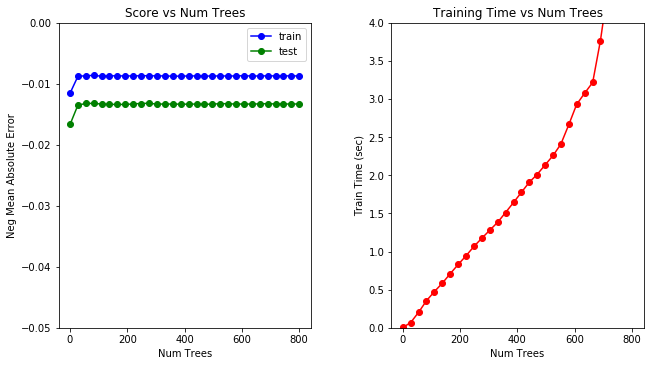

In [64]:
plot_results(tree_grid_search)

In [65]:
# Define a grid over only the maximum number of features
feature_grid = {'max_features': list(range(1, X_train.shape[1] + 1))}

In [67]:
# Create the grid search and fit on the training data
feature_grid_search = GridSearchCV(rf, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'neg_mean_absolute_error')
feature_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    6.8s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

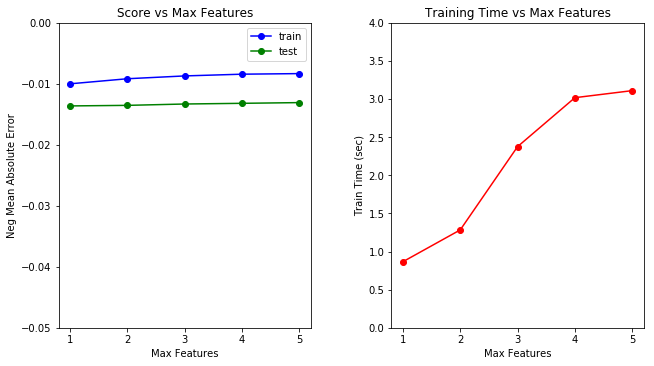

In [68]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

In [69]:
feature_grid

{'max_features': [1, 2, 3, 4, 5]}